In [3]:
# Install igraph
!pip install igraph

# move to the directory where the foodweb graphs are located.
import os
import itertools

# importing libraries
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
from collections import Counter

import pickle

# display plots in the notebook
%matplotlib inline
from matplotlib import rcParams

from datetime import datetime

from IPython.display import HTML, display
import time

Defaulting to user installation because normal site-packages is not writeable


In [12]:
class Progress():
  def __init__(self, max=100, title_name='', status=''):
    self.max = max
    if title_name != '':
      title_name += ': '
    self.title_name = title_name
    self.status = status
    self.progress_bar = display(self.progress(0, self.status), display_id=True)

  def show(self, value, status = None):
    self.progress_bar.update(self.progress(value, status))

  def progress(self,value,status):
    """
    A progress bar.
    """
    if status is not None:
      self.status = status
    return HTML("""
    <label for='text'>{title_name} {status}</label>
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=self.max, title_name=self.title_name, status=self.status))
    
def create_folder(path):
    folder = os.path.dirname(os.path.abspath(path))
    if os.path.exists(folder) is False:
        os.mkdir(folder)
        return True
    return False

### Connectivity value of G

Given a directed graph $G = (V, E)$

$f(G) = \sum_{i=1}^\mathcal{l} {|C_i| \choose 2} $

Where:

* $C_1,...,C_{\mathcal{l}}$ are the strongly connected components of the graph $G$
* $|\cdot|$ is the cardinality of a subset

In [5]:
def f_G(G):
  C = G.components(mode='strong')
  C_card = [len(c_i) for c_i in C]
  return np.sum(np.array([C_i * (C_i - 1) / 2 for C_i in C_card]))

In [6]:
def get_bowtie_structure(G):
    # Get the largest strongly connected component
    sccs = G.components(mode=ig.STRONG)
    max_scc = max(sccs, key=len)
    # Convert to set for efficiency
    max_scc = set(max_scc)
    # Compute the IN and OUT sets
    ## Compute the nodes that reaches each vertex of the SCC
    reachable_in = G.neighborhood(vertices=max_scc, order=G.vcount(), mode='in', mindist=0)
    ## Convert to a set for efficiency
    reachable_in = set(itertools.chain.from_iterable(reachable_in))

    ## Compute the nodes that are reached by each vertex of the SCC
    reachable_out = G.neighborhood(vertices=max_scc, order=G.vcount(), mode='out', mindist=0)
    ## Convert to a set for efficiency
    reachable_out = set(itertools.chain.from_iterable(reachable_out))

    ## Finally compute the sets
    in_set = reachable_in - max_scc
    out_set = reachable_out - max_scc

    # Compute the Tubes, Tendrils IN sets
    tubes = set()
    tendrils_in = set()

    in_neighbors = G.neighborhood(vertices=in_set, order=G.vcount(), mode='out', mindist=0)
    in_neighbors = set(itertools.chain.from_iterable(in_neighbors))
    neighbors_to_be_tested = in_neighbors - max_scc - out_set - in_set

    for n in neighbors_to_be_tested:
        out_neighbors_n = set(G.neighborhood(vertices=n, order=G.vcount(), mode='out', mindist=0))
        if len(out_neighbors_n.intersection(out_set)) == 0:
            tendrils_in.add(n)
        else:
            tubes.add(n)

    # Compute the Tendrils OUT and the Disconnected sets
    tendrils_out = set()
    disconnected = set()

    all_others_nodes = set([v.index for v in G.vs()]) - max_scc - in_set - out_set - tendrils_in - tubes

    for n in all_others_nodes:
        out_neighbors_n = set(G.neighborhood(vertices=n, order=G.vcount(), mode='out', mindist=0))
        if len(out_neighbors_n.intersection(out_set)) == 0:
            disconnected.add(n)
        else:
            tendrils_out.add(n)

    sets = {
        'Core': max_scc,
        'IN set': in_set,
        'OUT set': out_set,
        'Tubes': tubes,
        'Tendrils IN': tendrils_in,
        'Tendrils OUT': tendrils_out,
        'Disconnected set': disconnected
    }

    return sets


def get_bowtie_dataframe(G_dataset, frac=True):
  names_column = []
  core, in_set, out_set, tubes, tendrils_in, tendrils_out, disconnected = [], [], [], [], [], [], []
  for G in G_dataset:
    V = G.vcount()
    names_column.append(G['name'])
    components = get_bowtie_structure(G)
    core.append(len(components['Core']))
    in_set.append(len(components['IN set']))
    out_set.append(len(components['OUT set']))
    tubes.append(len(components['Tubes']))
    tendrils_in.append(len(components['Tendrils IN']))
    tendrils_out.append(len(components['Tendrils OUT']))
    disconnected.append(len(components['Disconnected set']))
    if frac:
      core[-1] = core[-1] / V
      in_set[-1] = in_set[-1] / V
      out_set[-1] = out_set[-1] / V
      tubes[-1] = tubes[-1] / V
      tendrils_in[-1] = tendrils_in[-1] / V
      tendrils_out[-1] = tendrils_out[-1] / V
      disconnected[-1] = disconnected[-1] / V

  bow_tie = pd.DataFrame({
                            'Core': core,
                            'In': in_set,
                            'Out': out_set,
                            'T-In': tendrils_in,
                                    }, index=names_column)
  return bow_tie

def visual_style(g, layout=None, size_mode=None):
  # set layout
  if layout is None:
    layout = g.layout_fruchterman_reingold(niter=1000)

  # these properties will be used to set the graph aspect
  try:
    weights = [e['weight'] for e in g.es()]
  except:
    weights = [1.0 for e in g.es()]
  betweenness = g.betweenness()
  eigenvector = g.eigenvector_centrality()

  palette = {
    1: '#1f77b4',
    2: '#ff7f0e',
    3: '#2ca02c',
    4: '#d62728',
    5: '#9467bd',
  }

  visual_style = {}
  # set visual style
  visual_style = {}
  ## set vertex labels to be the name of the vertex of the graph
  visual_style['vertex_label'] = [v['name'] for v in g.vs()]
  ## change label size according to the betweenness
  if size_mode == 'betweenness':
    visual_style['vertex_size'] = [b/max(betweenness)*0.7 + 0.1 for b in betweenness]
  elif size_mode == 'eigenvector':
    visual_style['vertex_size'] = [b/max(eigenvector)*0.7 + 0.1 for b in eigenvector]
  else:
    visual_style['vertex_size'] = 0.2
  ## change color according to the vertex 'ECO' property
  visual_style['vertex_color'] = [palette[v['ECO']] for v in g.vs()]
  ## change the width of the verteces
  visual_style['vertex_frame_width'] = 0.2


  ## set edge color to be gray. The higher the weight of the lower the transparancy
  visual_style['edge_color'] = [(0.5, 0.5, 0.5, 1) for w in weights]
  ## change edge width
  visual_style['edge_width'] = 0.1


  ## change vertex labels' size
  visual_style['vertex_label_size'] = 3

  ## set the layout into the dictionary
  visual_style['layout'] = layout

  return visual_style

In [7]:
def index_from_dataset(G_dataset, name):
  for i, G in enumerate(G_dataset):
    if G['name'] == name:
      return i
  print(f"{name} not found in dataset...")
  return None

In [9]:
# Collecting the graphs
## Option: to include or not include the "artificial nodes"

living_other = True

G_dataset = []

dataset_path = './dataset'
for file_name in sorted(os.listdir(dataset_path)):
  if file_name.endswith(".graphml"):
    print(f"Reading {file_name}:", end=' ')
    G = ig.Graph.Read_GraphML(os.path.join(dataset_path, file_name))
    print(f"{G['name']}")
    if f_G(G) > 0:
      if living_other:
        keep = list(np.argwhere(np.array(G.vs()['ECO']) == 1.0).ravel()) + list(np.argwhere(np.array(G.vs()['ECO']) == 2.0).ravel())
        G = G.subgraph(keep)
        degree_keep = G.degree()
        keep = list(np.argwhere(np.array(degree_keep) > 0).ravel())
        G = G.subgraph(keep)
      G_dataset.append(G)

Reading ChesLower.graphml: Lower Chesapeake Bay
Reading ChesMiddle.graphml: Middle Chesapeake Bay
Reading ChesUpper.graphml: Upper Chesapeake Bay
Reading Chesapeake.graphml: Chesapeake Bay Mesohaline
Reading CrystalC.graphml: Crystal River Creek - Control
Reading CrystalD.graphml: Crystal River Creek - Delta Temp
Reading Maspalomas.graphml: Charca de Maspalomas
Reading Michigan.graphml: Lake Michigan
Reading Mondego.graphml: Mondego Estuary - Zostrea site
Reading Narragan.graphml: Narragansett Bay Model
Reading StMarks.graphml: St. Marks River (Florida)
Reading artic_seas_29.graphml: Arctic seas
Reading baydry.graphml: Florida Bay - dry season
Reading baywet.graphml: Florida Bay - wet season
Reading cypdry.graphml: Cypress Dry Season
Reading cypwet.graphml: Cypress Wet Season
Reading finland_80.graphml: Lake Paajarvi, littoral zone, Finland
Reading finland_83.graphml: Lake Pyhajarvi, littoral zone, Finland
Reading gram.graphml: Everglades Graminoids
Reading little_rock.graphml: Little 

/tmp/ipykernel_18249/3693019174.py:12: RuntimeWarning: Could not add vertex ids, there is already an 'id' vertex attribute. at src/io/graphml.c:485
  G = ig.Graph.Read_GraphML(os.path.join(dataset_path, file_name))


In [10]:
def greedy_G_v(G, v, function=f_G):
  """
  Greedy strategy function:
  G is the graph
  v is the vertex to be tested
  f_G is the connectivity funciton measured AFTER the removal of from G.
  """
  G_temp = G.copy()
  G_temp.delete_vertices(v)
  return f_G(G_temp)

# def working(G):
# """
# Prototype
# """
#   list_of_removed_nodes = []
#   G_M = G.copy()
#   while(len([v for v in G_M.vs() if v['ECO'] == 1]) > 0):
#     nodes_order = [v for v in G_M.vs() if v['ECO'] == 1]
#     indices = [v.index for v in nodes_order]
#     f_G_del = [greedy_G_v(G_M, v) for v in nodes_order]
#     experiment = zip(nodes_order, f_G_del)
#     experiment = sorted(experiment, key = lambda x: x[0].index)
#     experiment = sorted(experiment, key = lambda x: x[1])
#     selected_node = experiment[0][0]
#     list_of_removed_nodes.append(selected_node['name'])
#     G_M.delete_vertices(selected_node)
#   return list_of_removed_nodes

def min_index(nodes, f_G_del, all=False):
  """
  This function sorts the nodes according to the measure f_G_del made upon the strategy
  and the indices of the vertex, so that if more than one vertex has the same f_G_del, then one with
  the least index is selected.
  """
  experiment = zip(nodes, f_G_del)
  experiment = sorted(experiment, key = lambda x: x[0].index)
  experiment = sorted(experiment, key = lambda x: x[1])
  if all: selected_node_s = [el[0] for el in experiment]
  else: selected_node_s = experiment[0][0]
  return selected_node_s

def node_removal_strategy(G,
                          measure_v = lambda G, v: greedy_G_v(G, v),
                          vertices_collecting_function = lambda G: [v for v in G.vs() if v['ECO'] == 1],
                          vertices_ordering_function = lambda nodes, f_G_del: min_index(nodes, f_G_del),
                          stop_condition = lambda G: len([v for v in G.vs() if v['ECO'] == 1]) > 0
                          ):
  """
  This function takes a graph and a strategy and returns the list of vertices that minimize the
  connectivity function according to the strategy.
  A strategy is composed by these elements:
  1. a measure on the vertices;
  2. a function that collects the vertices from the graph given the properties of the vertex;
  3. a function that sorts and collects the vertices given the measure;
  4. a stop condition that stops the loop on the graph;

  With a combination of these 4 elements it is possible to test different strategies.
  For example, one may test how does it change the connectivity value of the graph
  when the vertices that minimize the most the connectivity value are removed first.
  In this case, the measure on the vertices is the connectivity function given the graph after the removal of a vertex;
  the function that collects the vertices is a function that takes all vertices of the graph regardless their properties;
  the sorting and collecting function sorts the vertices according to the measured connectivity function after their removal and collect
  the vertex that minimize the most the connectivity; the loop stop when there are no more vertices in the graph, i.e. when the graph is empty.
  """

  # 1. List to be returned: the nodes given the ordering and the function
  list_of_removed_nodes = []
  # 2. G.delete_vertices in an inplace function, therefore a dummy variable is needed
  G_M = G.copy()
  # 3. Loop on the graph given a condition
  while(stop_condition(G_M)):
    # 3.1 Collect the nodes with a fixed order
    v_order = vertices_collecting_function(G_M)
    # 3.2 Measure the vertices property given by measure_v
    f_G_del = [measure_v(G_M, v) for v in v_order]
    # 3.3 Sort and select the vertices
    selected_v_s = vertices_ordering_function(v_order, f_G_del)
    # 3.4 Handling different strategies: vertices_ordering_function can return a single vertex of a list of vertices
    if type(selected_v_s) == list:
      list_of_removed_nodes = [v['name'] for v in selected_v_s]
    else:
      list_of_removed_nodes.append(selected_v_s['name'])
  #Node(s) is removed to meet the stop condition
    G_M.delete_vertices(selected_v_s)
  return list_of_removed_nodes

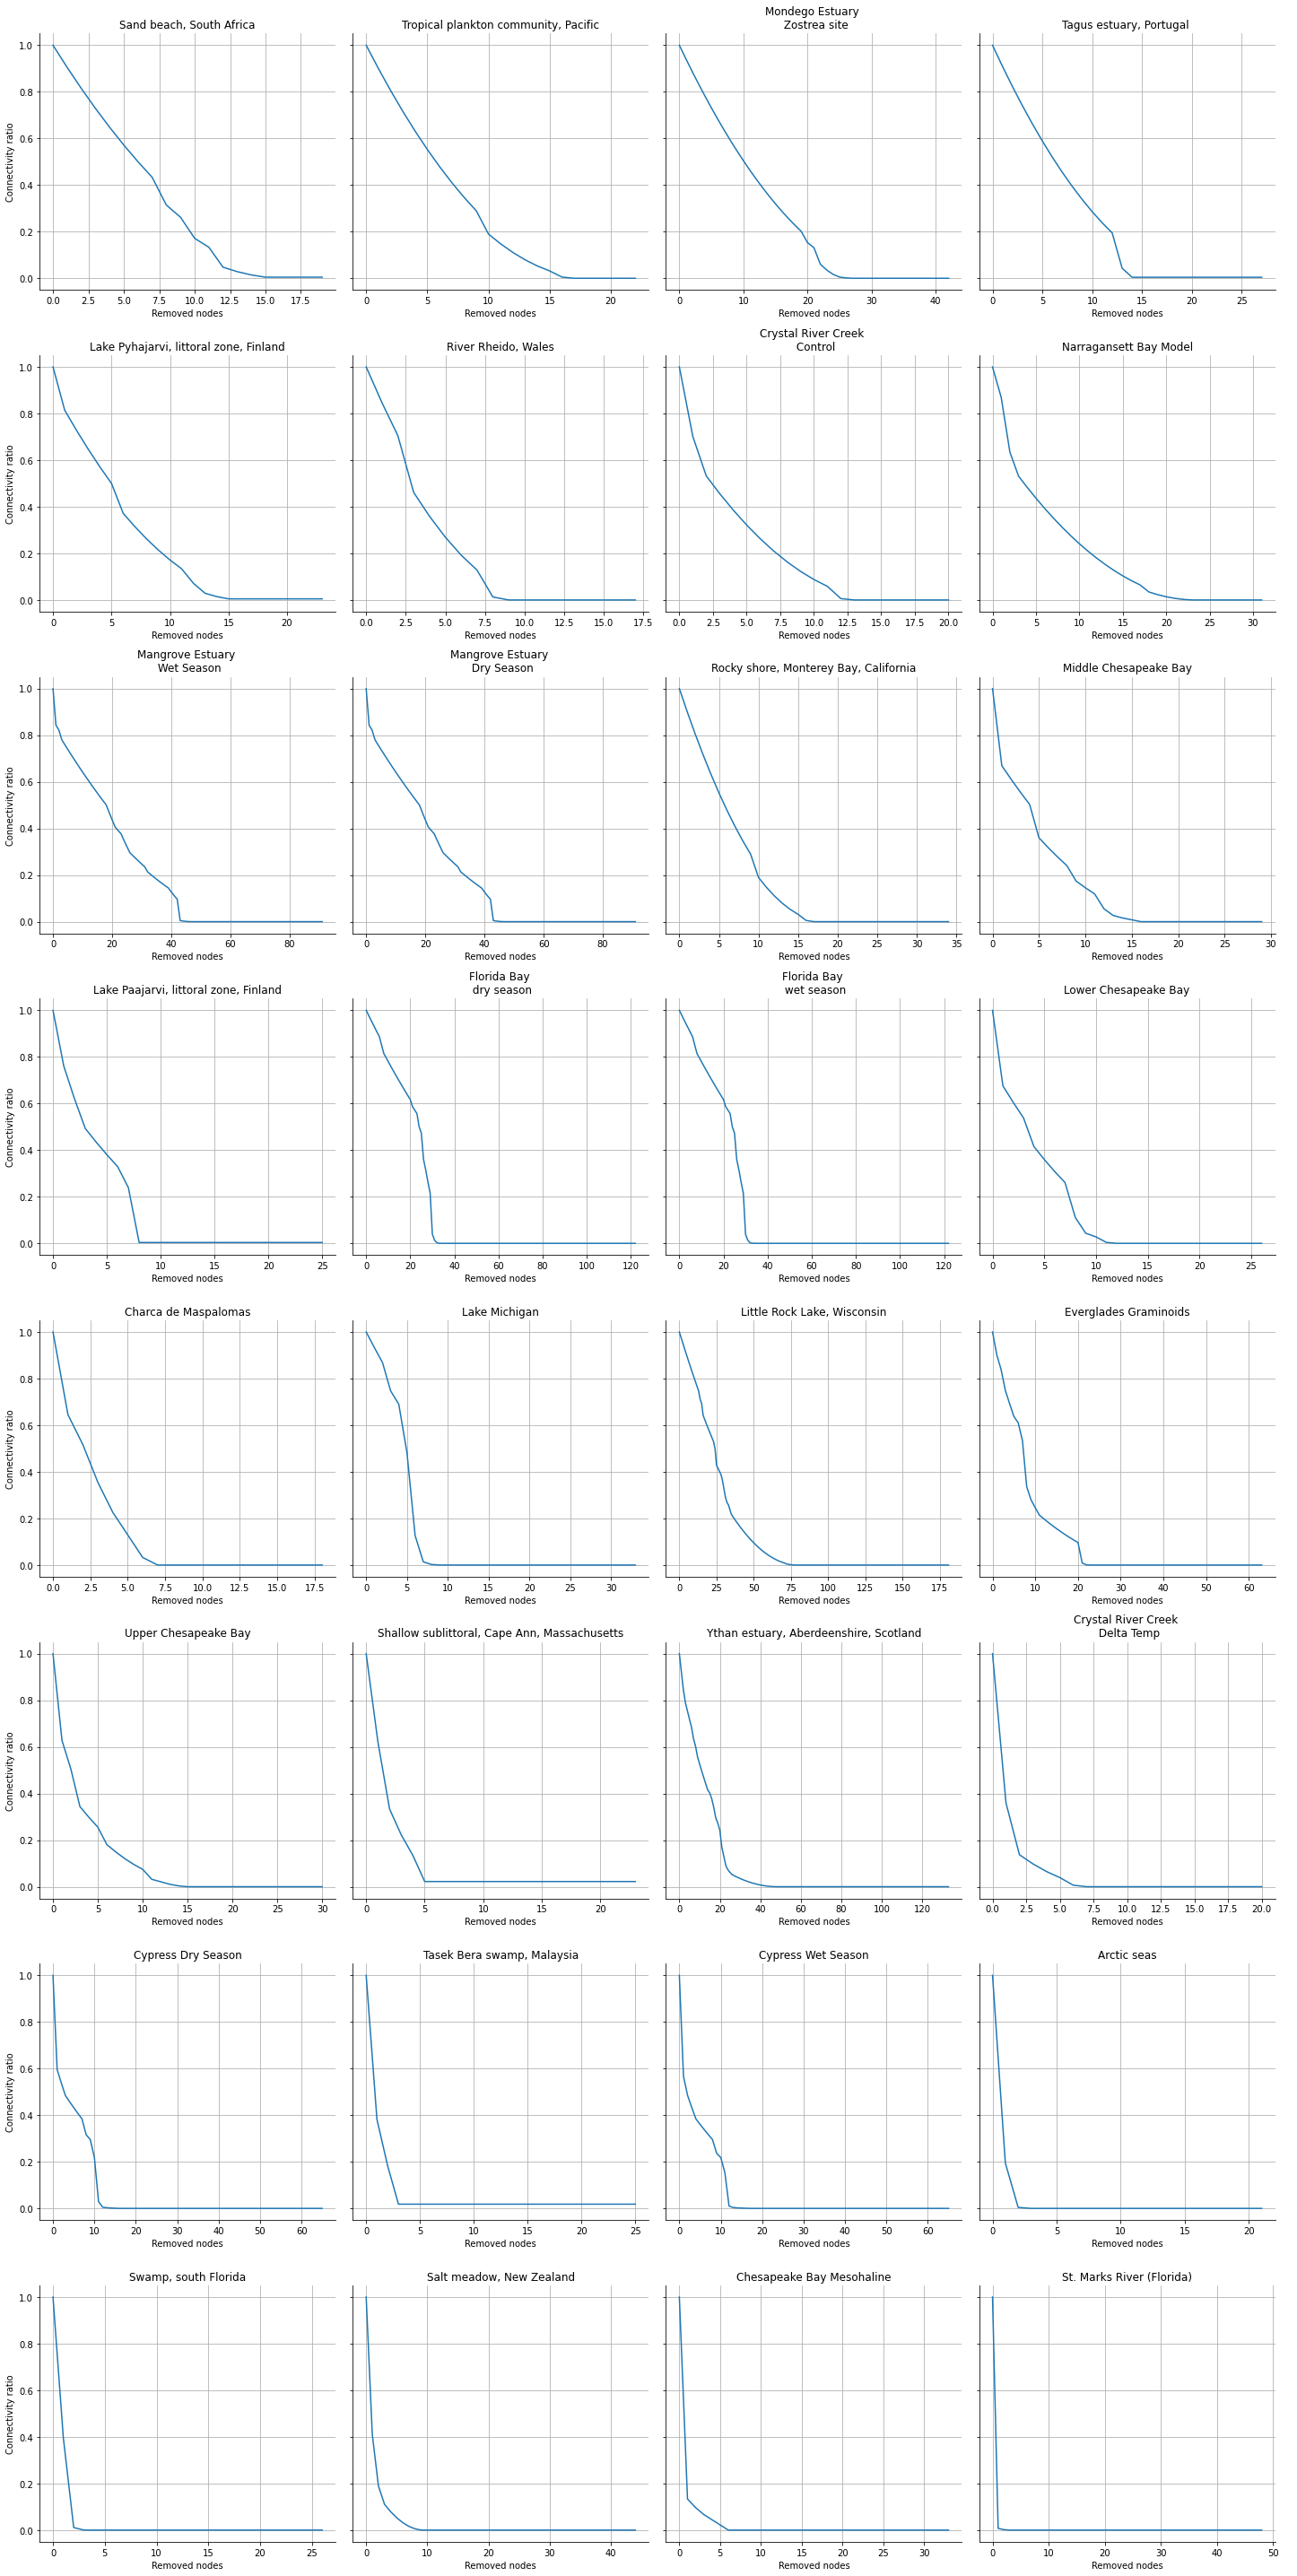

In [14]:
#@title Robustness and node sequence

df_robustness_path_filename = './Figures and Tables/robustness.pickle' #@param {type: "string"}
df_node_sequence_path_filename = './Figures and Tables/node_sequence.pickle' #@param {type: "string"}
sequence_image_path = './Figures and Tables/Robustness.pdf' #@param {type: "string"}
mode = 'load' #@param ['load', 'save']

create_folder(df_robustness_path_filename)
create_folder(df_node_sequence_path_filename)
create_folder(sequence_image_path)

def get_f_G_removal_node_sequence(G, list_of_removed_nodes):
  G_temp = G.copy()
  f_G_max = f_G(G_temp)
  rows_G.append((graph_name, 'No nodes removed', 1))
  for vertex in list_of_removed_nodes:
    G_temp.delete_vertices(vertex)
    rows_G.append((graph_name, vertex, f_G(G_temp) / f_G_max))

  return pd.DataFrame(rows_G, columns=['graph_name', 'node_removed', 'f_G_value'])

def robustness_function(df_node_removal_G):
  values = df_node_removal_G['f_G_value'].to_numpy()
  N = df_node_removal_G.index[-1]
  return np.sum(values) / N

df_node_removal = []
df_robustness = []
iprog = 0
out = Progress(len(G_dataset), title_name='Robustness of graph')
for G in G_dataset:
  graph_name = G['name']
  out.show(iprog, status=graph_name)
  rows_G = []
  list_of_removed_nodes = node_removal_strategy(G)
  df_node_removal_G = get_f_G_removal_node_sequence(G, list_of_removed_nodes)
  rho_G = robustness_function(df_node_removal_G)
  df_robustness.append((graph_name, rho_G))
  df_node_removal.append(df_node_removal_G)
  iprog += 1
df_node_removal = pd.concat(df_node_removal)
df_robustness = pd.DataFrame(df_robustness, columns = ['graph_name', 'rho_G'])
order_plot = df_robustness.sort_values(by='rho_G', ascending=False)['graph_name'].to_list()

g = sns.FacetGrid(df_node_removal.reset_index(), col="graph_name", height=5, col_wrap=4, sharex=False, col_order=order_plot)
g.map_dataframe(sns.lineplot, x='index', y='f_G_value')
g.figure.subplots_adjust(wspace=0, hspace=0)

for col_val, ax in g.axes_dict.items():
  ax.set_title(col_val.replace('-', '\n'))
  ax.set_ylabel("Connectivity ratio")
  ax.set_xlabel("Removed nodes")
  ax.grid()

g.tight_layout()
g.add_legend()
g.savefig(sequence_image_path)

df_node_removal.to_pickle(df_node_sequence_path_filename)
df_robustness.to_pickle(df_robustness_path_filename)

,Core,In,Out,T-In
Lower Chesapeake Bay,0.793103,0.137931,0.034483,0.034483
Middle Chesapeake Bay,0.875000,0.125000,0.000000,0.000000
Upper Chesapeake Bay,0.727273,0.242424,0.030303,0.000000
Chesapeake Bay Mesohaline,0.444444,0.555556,0.000000,0.000000
Crystal River Creek - Control,0.904762,0.095238,0.000000,0.000000
Crystal River Creek - Delta Temp,0.857143,0.142857,0.000000,0.000000
Charca de Maspalomas,0.333333,0.666667,0.000000,0.000000
Lake Michigan,0.882353,0.117647,0.000000,0.000000
Mondego Estuary - Zostrea site,0.813953,0.186047,0.000000,0.000000
Narragansett Bay Model,0.937500,0.062500,0.000000,0.000000


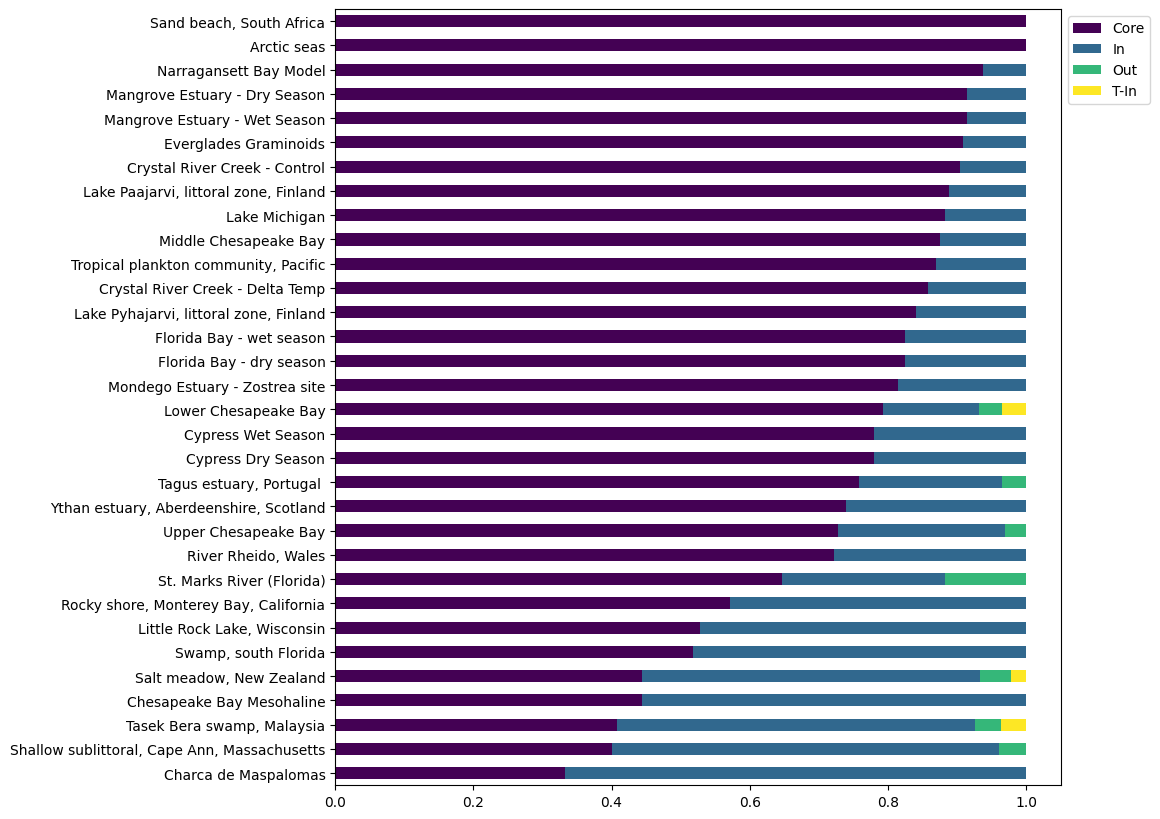

In [ ]:
#@title Periphery analysis
image_out_path = './Figures and Tables/Periphery Structure.pdf' #@param {type: "string"}
network_bowtie_df_outpath = './Figures and Tables/Periphery Structure.pickle'
network_bowtie_df = get_bowtie_dataframe(G_dataset)
display(network_bowtie_df)

fig, ax = plt.subplots(figsize=(11.7 ,8.3))
network_bowtie_df.sort_values(by='Core', ascending = True).plot(kind = 'barh', stacked = True, layout='constrained', ax=ax, colormap='viridis')
ax.legend(bbox_to_anchor=(1,1))
fig.tight_layout()
fig.savefig(image_out_path)
network_bowtie_df.to_pickle(network_bowtie_df_outpath)